# Modelling the concurrency pattern of RPC calls with a directed acyclic graph

Consider a call-tree of remote procedure calls in a distributed system. We designate a branch of the tree a *transaction*; a the term *transaction tree* is a synonym for the distributed call tree. 

For the sake of this work book each transaction consists of a pair of events: its start (the request is sent) and its end (the reply is received). For example, `{X` means the beginning of transaction X; `X}` denotes the end of it.

Our goal is to capture the order and timing of these events for the purpose of anomaly detection in the distributed system. For example, we want to detect if a transaction takes abnormally long or if the shape of the transaction tree is unusual because of missing or superflous branches. This is an ambitious goal: we tackle it by analysing the transactions of the tree one-by-one in relation to their direct children only. That is, we restrict the analysis to the order and timeing of the set of events consisting of the start and end of a parent transaction and the start and end events of its direct children. We call these together *event set*.

We work with synthetic data. The data is synthetised so that the time gap between pairs of events related by causality is chosen from a log-normal distribution. Input to the synthesis is a *concurrency structure*, i.e. the result of composing transaction-blueprints with the *'sequential execution'* and *'concurrent execition'* operators. Each transaction blueprint is parametrized with the $location$ and $scale$ parameters of the log-normal distribution from which we draw samples to emulate the time difference between the start and the end events of the transactions conforming to the blueprint. To simulate the delay between the most recent causally related event (such as the end of a prerequisit sibling transaction) and the start of the transaction, we use two global parameters, $\alpha$ and $\beta$. The delay is sampled from a log-normal with location $location+\alpha$ and scale $\frac{scale}{\beta}$.

Once we created a concurrency structure, we can generate a lot of event sets conforming to it by "taking samples" from the concurrency structure. Each sample is a full set of the events defined by the concurrency structure. We sort each set by the timestamp of the events. We call the time-difference between adjacent events *gaps*.

The concurrency model we want to train using the samples is a directed acyclic graph (DAG). The vertices of the DAG are the events defined by the concurrency structure. We add an edge between two nodes if in the training set there is at least one sample so that after sorting its events by time the events defined by the two nodes are adjecent. We associate two quantities with each edge: 

* Length: the mean of the time difference between the events in the population of the gaps conforming to the edge
* Width (or weight or spring strength): an approximation of the [odds](https://en.wikipedia.org/wiki/Odds) that one of the events is after the other (see the formula below)

The direction of the edge is chosen so that it points at the event that typically happens later. 

The DAG created this way represents typical timing relations among pairs of the events that may be adjecent in time. The obvious transitive timing relations are omitted. *The scope of this notebook is to visualize these graphs.*

Open questions:
* Could we recover the concurrency structures from these (or similar) graphs? 
* Could they be used to compute an anomaly score for an event set? 

## Create some test data
In the below '`-`' means serial, '`|`' means concurrent execution. For example, for the child transactions `A`, `B` and `C` of an unnamed parent transaction, with the concurrency pattern

    trx('A') - trx('B')|trx('C') 
    
the possible execustion schedules are:

    {A A} {B B} {C C}
    {A A} {B {C B} C}
    {A A} {B {C C} B} 
    {A A} {C C} {B B} 
    {A A} {C {B C} B} 
    {A A} {C {B B} C} 

where `{X` means the beginning of transaction X; `X}` denotes the end of it. Operator precedence is according to Python's rules.
### Write code to generate the timestamped events

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain

In [15]:
alpha=-1.; beta=10.;

We model the concurrency structure with a tree. The leaves are `Trx` instances; `Parallel` and `Sequential` instances combine leaves and/or branches.

In [16]:
class _NonSeq(object):
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.append(self)
            return other
        else:
            return Sequential((self, other))

class _NonPar(object):
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.append(self)
            return other
        else:
            return Parallel((self, other))

class Sequential(list, _NonPar):
    
    def __str__(self):
        return "(" + " - ".join(str(x) for x in self) + ")"
    __repr__ = __str__
        
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def collect_events(self, events, refTime=0):
        for child in self:
            refTime = child.collect_events(events, refTime) 
        return refTime

class Parallel(list, _NonSeq):

    def __str__(self):
        return "(" + " | ".join(str(x) for x in self) + ")"
    __repr__ = __str__
    
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def collect_events(self, events, refTime=0):
        return max(child.collect_events(events, refTime) for child in self)
            
class Trx(_NonSeq, _NonPar):
    
    def __init__(self, name, loc=0., scale=1.):
        self.name, self.loc, self.scale = name, loc, scale
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "Trx('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "Trx('{}')".format(self.name)
    __repr__ = __str__
        
    def collect_events(self, events, refTime=0):
        start  = refTime + np.exp(np.random.normal(self.loc + alpha, self.scale / beta))
        finish = start   + np.exp(np.random.normal(self.loc        , self.scale       ))
        events.extend([(start, "{" + self.name), (finish, self.name + "}")])
        return finish
        

The `collect_events` mehod of the above classes generate a sample of the concurency structure assembled from the instances. The sample is created recursively. `Sequential` and `Parallel` objects take care to sample their children in the right order, passing each child the timestamp of the event preceeding it. `Trx` objects generate a *begin* and  a *finish* timestamps, both according to a log-normal distribution. (The parameters of the distribution can be set in the constructor.)


Below are a few convienence methods:

In [17]:
def collect_events(structure):
    events = list()
    structure.collect_events(events)
    events.sort()
    return events

def print_events(structure):
    for event in collect_events(structure):
        print "{1}: {0:5.3f}".format(*event)

In [18]:
print_events((Trx('A') - Trx('B')) | Trx('C'))

{A: 0.351
{C: 0.440
C}: 0.625
A}: 5.542
{B: 5.972
B}: 9.125


### Visualize the generated data
The below graphs are created from the samples of a concurrency structure. Each event becomes a node of the graph. The events in the samples are sorted by their timestamps. We map every pair of subsequent events to an edge and record on it the time gap between the events. 

In [19]:
from collections import defaultdict
def get_samples(structure, n_samples):
    gaps = defaultdict(list)  # {(from, to): count}
    for _ in range(n_samples):
        from_ = 'start'
        prev_ts = 0
        for ts, to in collect_events(structure):
            gaps[from_, to].append(ts-prev_ts)
            from_ = to
            prev_ts = ts
        gaps[to, 'end'].append(.1)
    # merge edges in opposing directions
    merged = dict()
    while gaps:
        (from_, to), deltas = gaps.popitem()
        try:
            opposite_deltas = merged[(to, from_)]
        except KeyError:
            merged[(from_, to)] = deltas
        else:
            opposite_deltas.extend((-x for x in deltas))
    return merged

In [20]:
data = get_samples((Trx('A') - Trx('B')) | Trx('C'), 5)
for d, v in data.items():
    print d, v

('start', '{A') [0.34058470193497992, 0.38511192872511174, 0.28967496632398415]
('C}', 'B}') [1.4172429285437538, -0.032367721961564122]
('A}', '{B') [0.41710214980751492, 0.35523827970186694, 0.35902645631032293, 0.30197878271161294, 0.38262520046390769]
('B}', 'end') [0.1, 0.1, 0.1, 0.1]
('{A', '{C') [0.069534947517104817, 0.023157194520613877, 0.090264939451451032, -0.056426737585146047, -0.037504525830854674]
('{C', 'C}') [1.5882986751939407, 0.64575796980177413, 0.060154679948984158]
('{B', 'C}') [0.69965411859255666]
('{A', 'A}') [0.70128810089302318, 0.63306138486258767]
('C}', 'end') [0.1]
('C}', 'A}') [6.8926241895271554, 8.9424218708299801, 0.5618679342872257]
('start', '{C') [0.35675649121948128, 0.35495316581443559]
('{B', 'B}') [0.40997739418014056, 1.7921552654624211, 1.917764136044684, 0.87477018430983877]


Here we do the visualization. We use `neato`s [spring layout](http://www.graphviz.org/pdf/neatoguide.pdf). The preferred length of the springs/edges is the mean of the gaps (if negative, the edge direction is flipped). The strength of the springs is

$$D = \frac{1 + \#\ of\ positive\ gaps}{1 + \#\ of\ negative\ gaps}$$

In [21]:
def show_graph(data):
    plt.figure(figsize=(15,15))
    G=nx.DiGraph()
    max_weight = 0
    min_length = 0.1
    scale = 0.3
    for (from_, to), deltas in data.items():
        num = len(deltas)
        num_p = sum(d>0 for d in deltas)
        num_n = num - num_p
        mean = np.array(deltas).mean()
        std = np.array(deltas).std()
        #weight = num/(std + 0.1)
        weight = (1.+num_p)/(1.+num_n)
        if mean < 0:
            from_, to, weight, mean = to, from_, 1./weight, -mean
        G.add_edge(from_, to, weight=weight, len="{:4.2f}".format((mean+min_length)*scale))
        max_weight = max(max_weight, np.abs(weight))
    #pos=nx.spring_layout(G) # positions for all nodes
    nx.nx_pydot.write_dot(G,'g.dot.txt')
    pos=nx.nx_pydot.graphviz_layout(G,prog='neato')
    nx.draw_networkx(G, pos, scale=0.5,
                     alpha = 0.2,
                     width = [d['weight']*10./max_weight for _, _, d in G.edges(data=True)],
                     edge_color = 'g'
                    )
    plt.show()

Let's start with a simple concurrency pattern.

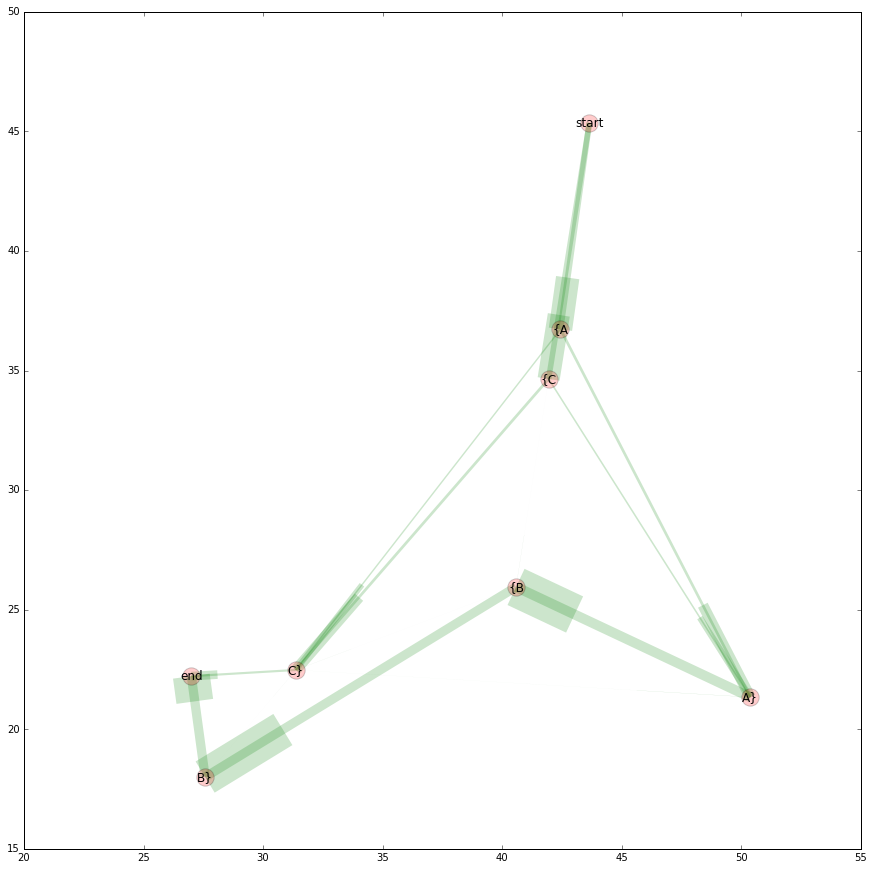

In [22]:
show_graph(get_samples((Trx('A') - Trx('B')) | Trx('C'), 1000))

Not too bad. Let's see a bit more elaborate example.

(Trx('B') - Trx('C') - (Trx('A') | Trx('A0') | Trx('A1') | Trx('A2') | Trx('A3') | Trx('A4') | Trx('A5') | Trx('A6') | Trx('A7') | Trx('A8') | Trx('A9')))


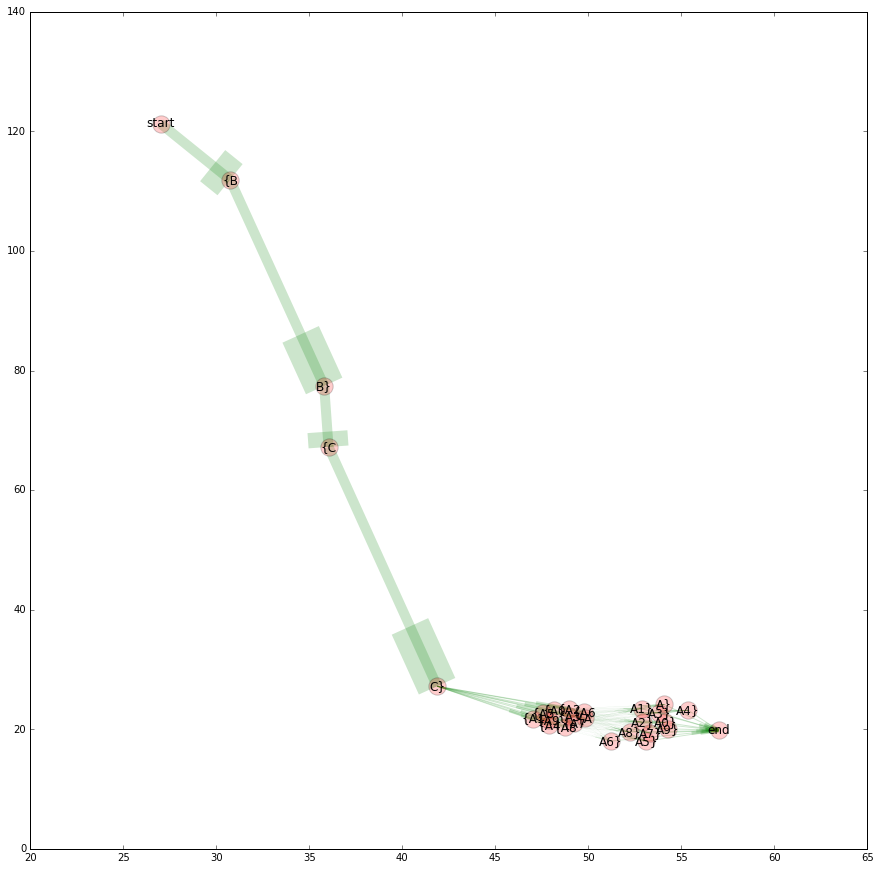

In [23]:
structure = Trx('A')
for i in range (10):
    structure |= Trx('A'+str(i))
structure -= Trx('B') - Trx('C')    
print structure
show_graph(get_samples(structure, 1000) )

Now a number of additional examples at random:

(((Trx('A') | Trx('B') | Trx('C') | Trx('D') | Trx('E')) - Trx('F')) | Trx('G'))


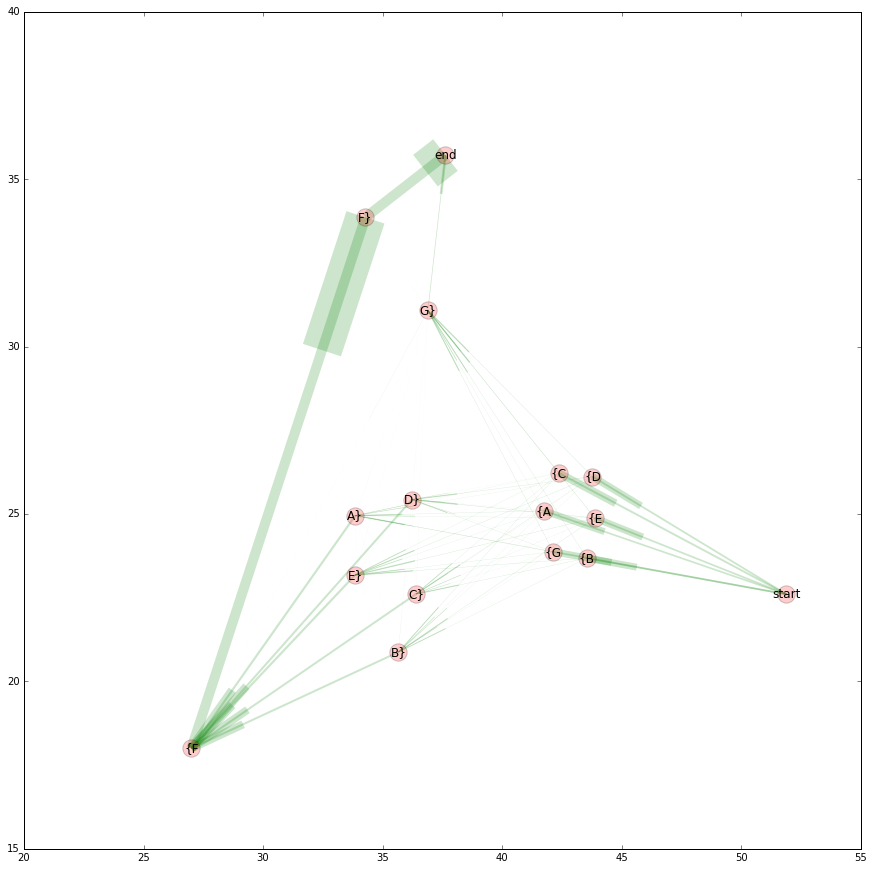

(((Trx('A') - Trx('B')) | Trx('C')) - Trx('D') - Trx('E') - Trx('F') - Trx('G'))


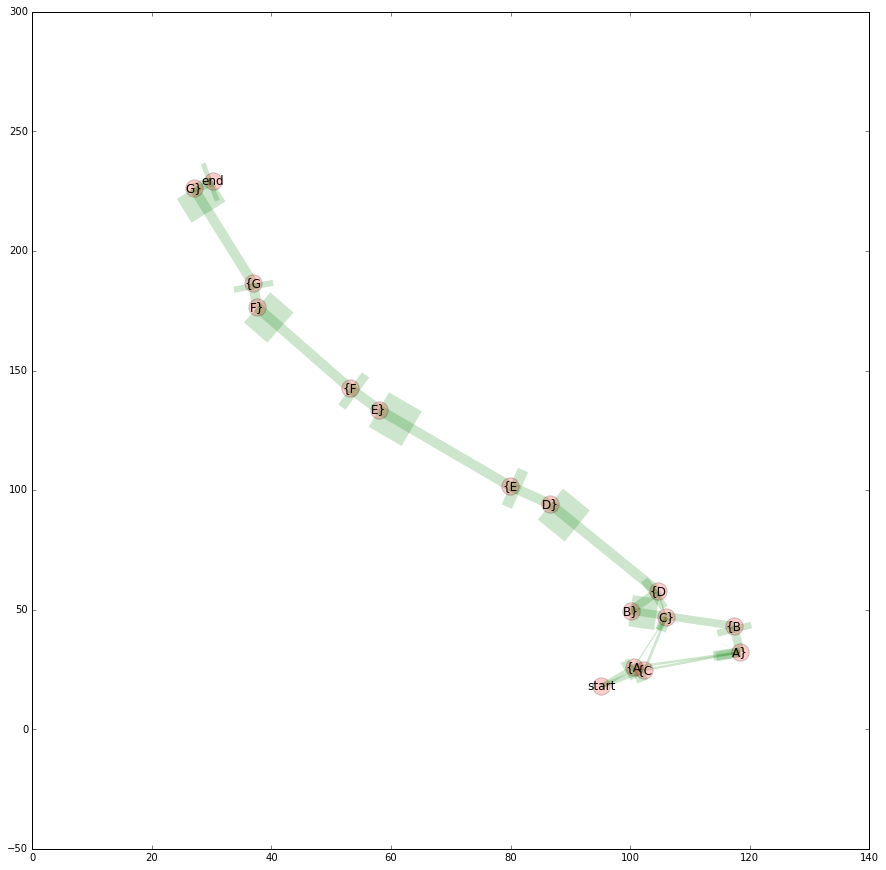

(((Trx('A') - Trx('B') - Trx('C')) | Trx('D')) - Trx('E') - Trx('F') - Trx('G'))


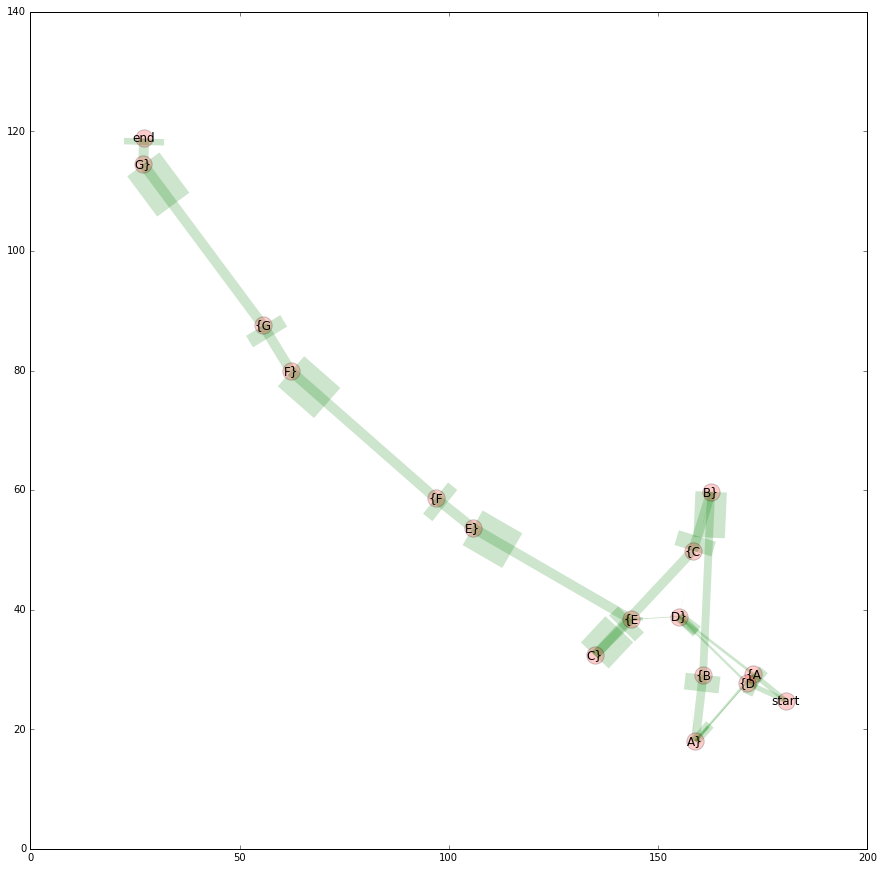

(((Trx('A') | Trx('B') | Trx('C')) - Trx('D')) | Trx('E') | Trx('F') | Trx('G'))


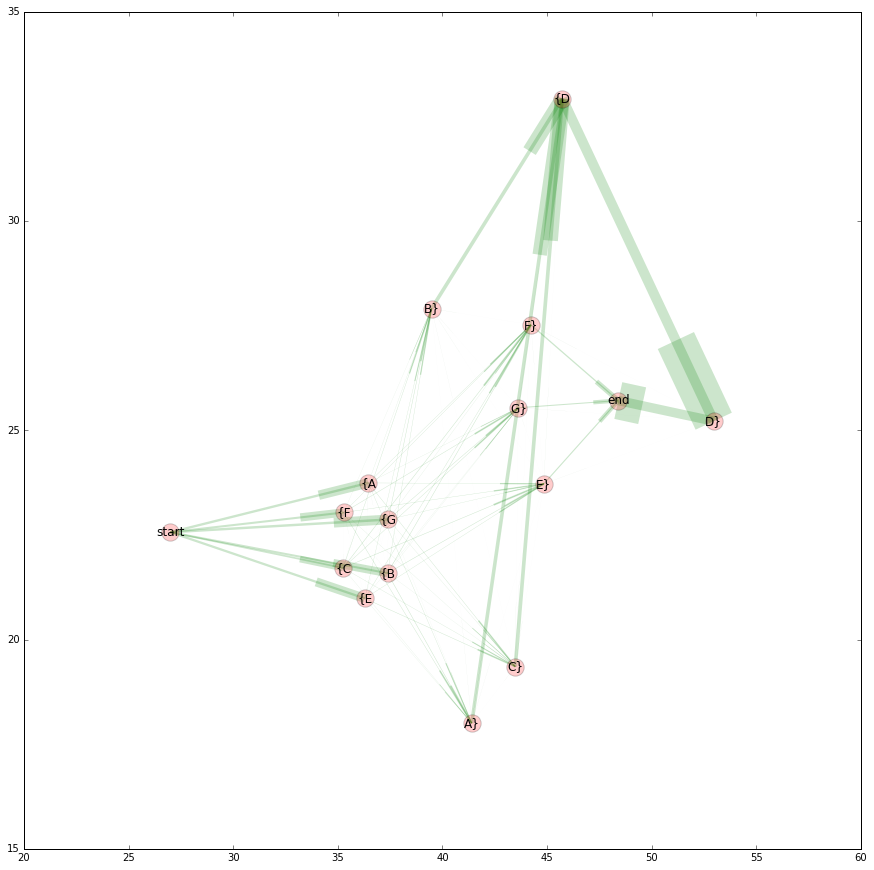

((Trx('A') | Trx('B') | Trx('C') | Trx('D') | Trx('E') | Trx('F')) - Trx('G'))


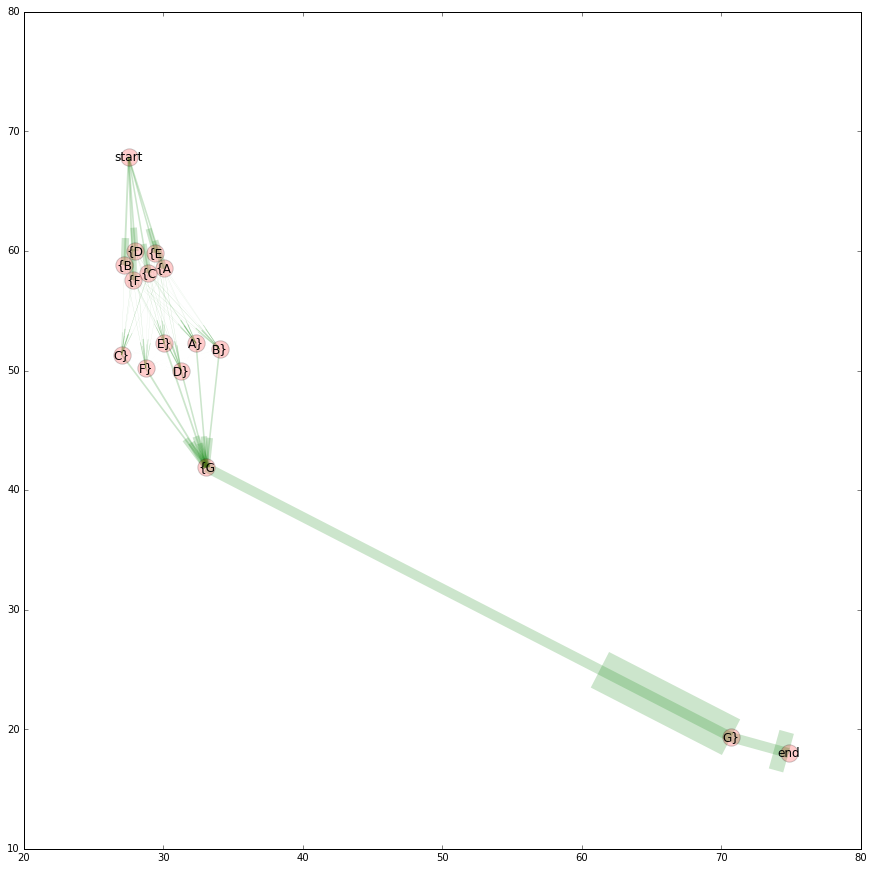

In [24]:
for i in range(5):
    structure = Trx('A')
    np.random.seed(i)
    for i in 'BCDEFG':
        if np.random.uniform() > 0.5:
            structure |= Trx(i)
        else:
            structure -= Trx(i)
    print structure
    show_graph(get_samples(structure, 1000) )

Let's be more real-life: vary the location and spread of the response times

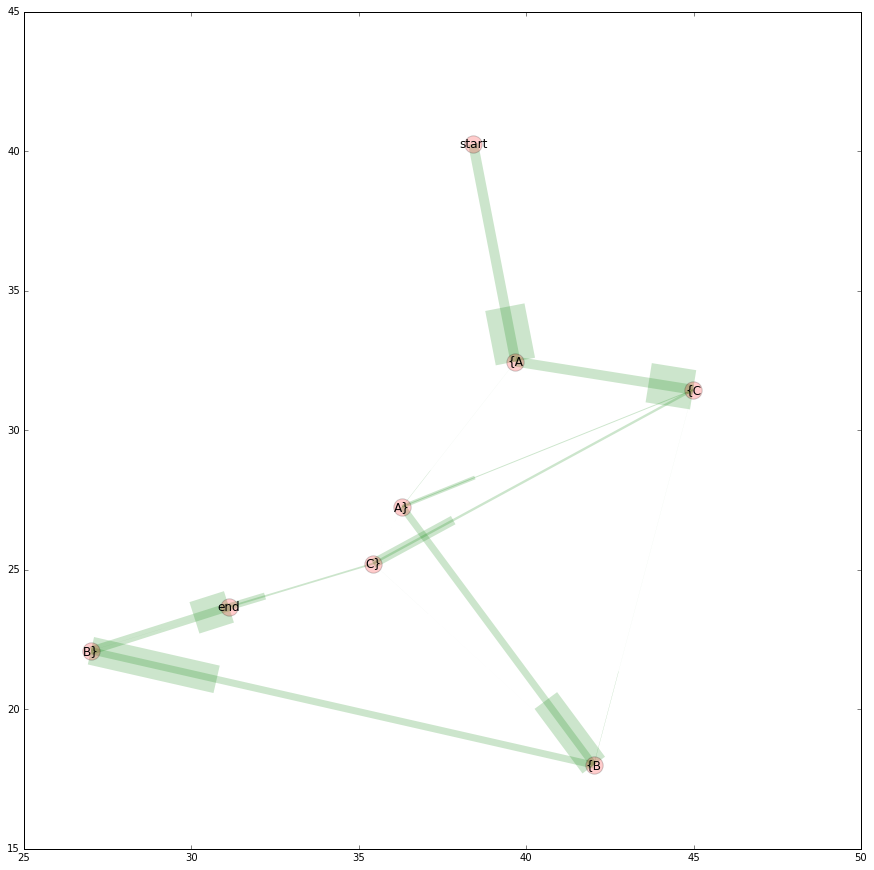

In [25]:
show_graph(get_samples((Trx('A', -0.5, .5) - Trx('B', +0.5, 1.5)) | Trx('C'), 1000))

(((Trx('A') | Trx('B', 0.0, 0.8) | Trx('C', 0.0, 0.5) | Trx('D', -0.1, 0.9) | Trx('E', -0.1, 0.8)) - Trx('F', 0.1, 1.0)) | Trx('G', -0.4, 0.1))


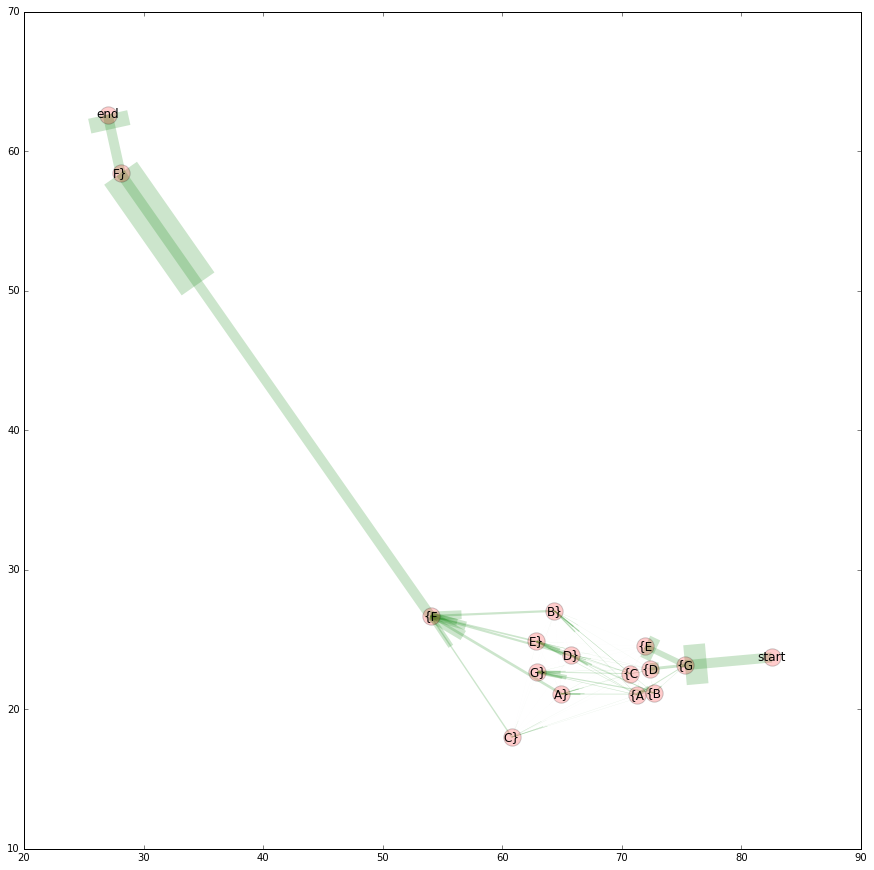

((((Trx('A') - Trx('B', -0.1, 0.8) - Trx('C', -0.2, 0.2) - Trx('D', -0.3, 0.4)) | Trx('E', 0.0, 0.5)) - Trx('F', -0.3, 0.9)) | Trx('G', 0.2, 0.5))


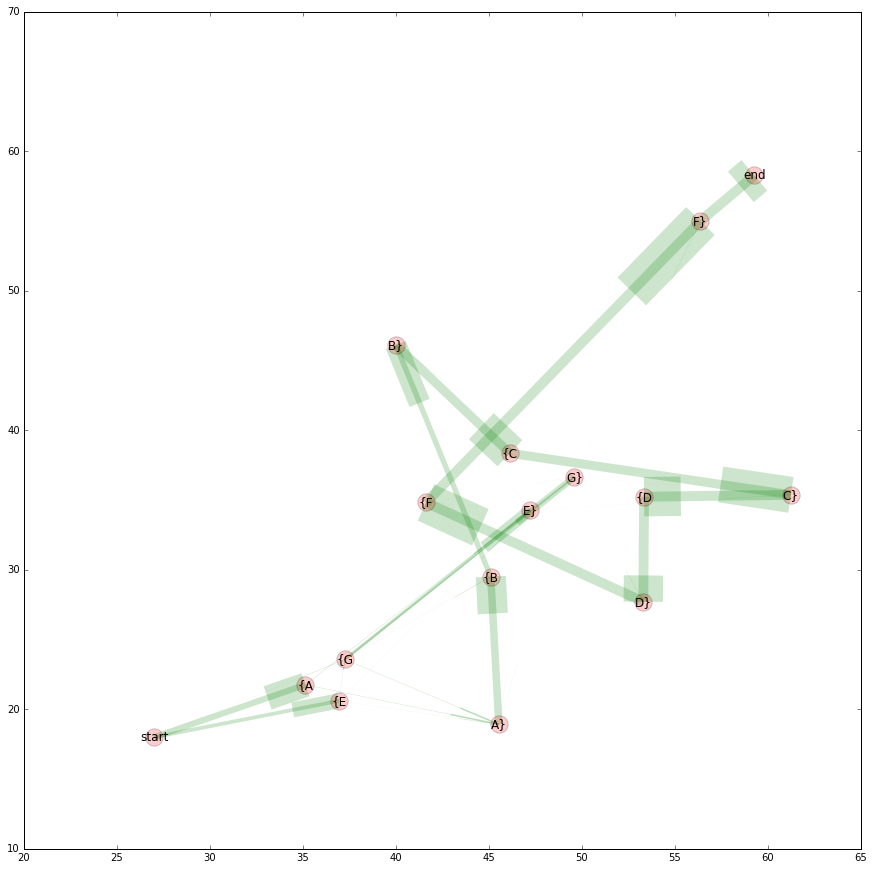

((((Trx('A') | Trx('B', -0.1, 0.1)) - Trx('C', -0.1, 0.5) - Trx('D', -0.3, 0.7)) | Trx('E', -0.2, 0.7)) - Trx('F', -0.4, 0.6) - Trx('G', 0.3, 0.9))


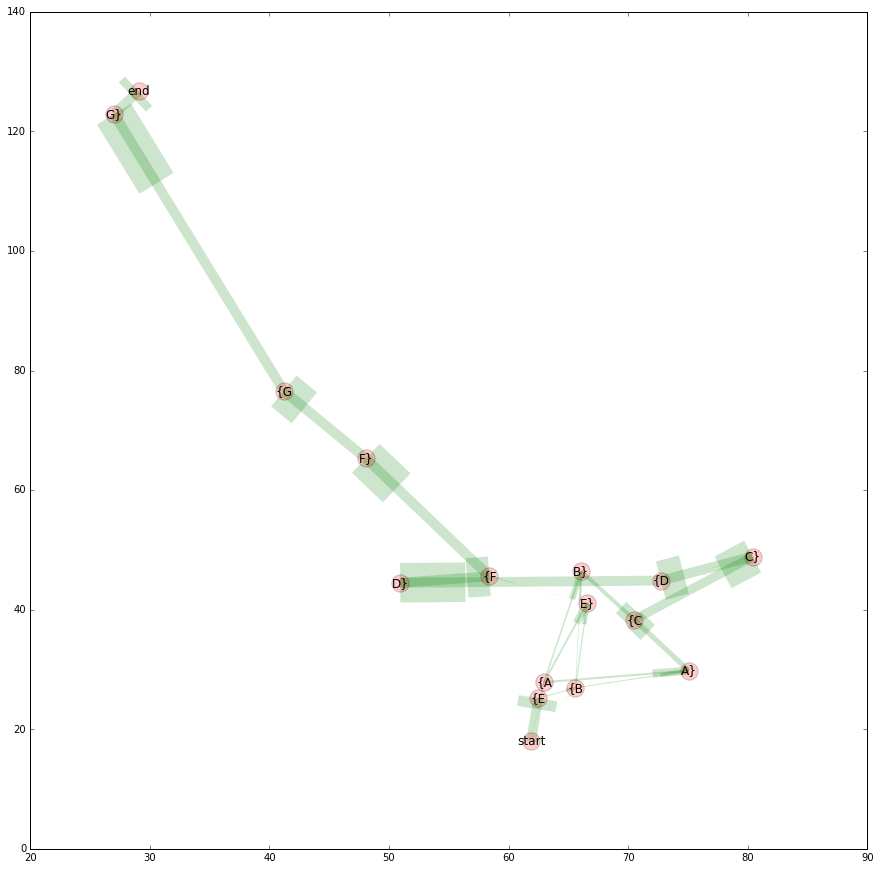

((((Trx('A') - Trx('B', 0.1, 0.8)) | Trx('C', 0.0, 0.9)) - Trx('D', -0.4, 0.3) - Trx('E', -0.1, 0.1)) | Trx('F', 0.1, 0.3) | Trx('G', 0.1, 0.1))


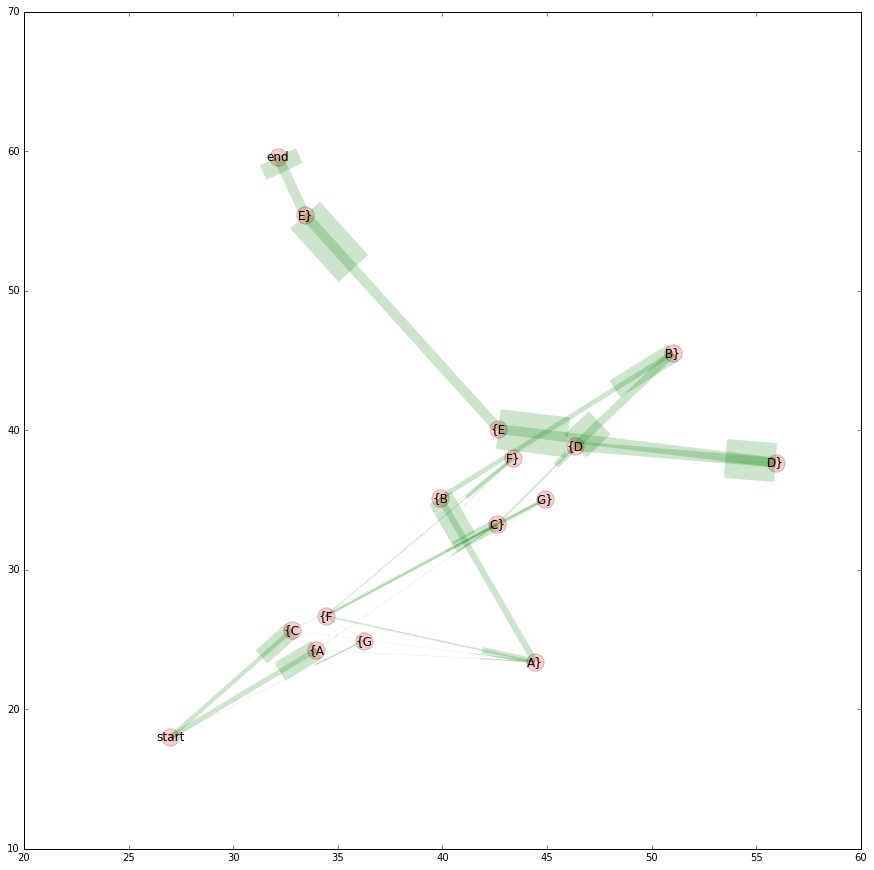

((Trx('A') | Trx('B', 0.5, 0.6)) - Trx('C', 0.2, 0.7) - Trx('D', 0.5, 0.1) - Trx('E', -0.1, 0.8) - Trx('F', 0.4, 1.0) - Trx('G', 0.1, 0.1))


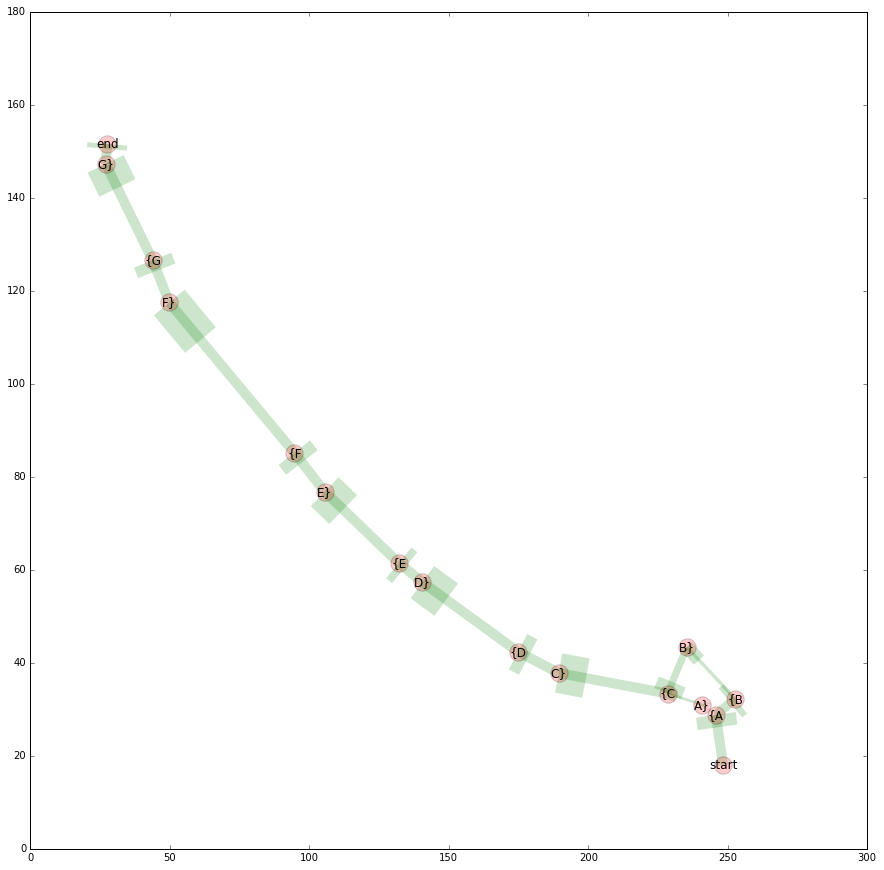

In [26]:
for i in range(5):
    structure = Trx('A')
    np.random.seed(i)
    for i in 'BCDEFG':
        loc = np.random.uniform() -0.5
        spread = np.random.uniform() + 0.05
        if np.random.uniform() > 0.5:
            structure |= Trx(i, loc, spread)
        else:
            structure -= Trx(i, loc, spread)
    print structure
    show_graph(get_samples(structure, 1000) )

These graphs do not give back exactly the true concurrency structure but they still capture some pattern.

Could they be used to generate an anomaly score for individual transactions?